## Problem 2 (Ising Model)
Test cases for the Python code below are shown at the end of the code. We vary the parameters $\theta$ and $T$ (temperature) to reflect the performance of the model at extreme values.

A discussion follows the test cases. Some notes guiding the model are given below if needed.

### Notes (if needed)
#### On the pipeline
The basic pipeline of the model is as follows:
$$\fbox{(A) Process image} \rightarrow \fbox{(B) Initialize state} \rightarrow \fbox{(C) Try to flip random pixel} \xrightarrow{\text{if (1)}} \fbox{(D) Flip pixel},$$
where condition (1) can be described as the flip either resulting in a lower energy for the system or being randomly chosen (to escape local maxima), and step (D) loops back to step (C) until all iterations have been passed.

#### On the algorithm
Let $\pi_{T}$ be the invariant distribution for the system at temperature $T$. The pseudocode for our implementation of the Ising model is as follows:

> (Step $0$) Get the normalized grayscale of the image. Set $X_{0} = \xi^{(i)},$ for $i$ the grayscale matrix with entries rounded to either $+1$ or $-1$.

> (Step $n \rightarrow n+1$) Pick a random state $\xi^{(j)}$ by flipping a random pixel $p = (x, y)$ in $X_{n}$ (i.e., setting $\xi^{(i)}(p) = -\xi^{(i)}(p)$). Compute the change $\Delta J = J(\xi^{(j)}) - J(\xi^{(i)})$ in energy
> 
> $$\Delta J = J(\xi^{(i)}) - J(\xi^{(j)}) = -\xi_{p}^{(i)}\sum_{k \neq p}{c_{p, k}\xi_{k}^{(i)}} - 2\theta B_{p}\xi_{p}^{(i)}$$
> 
> as a result of this flip. If $\Delta J \leq 0,$ accept the flip ($X_{n+1} = \xi^{(j)}$). Otherwise, compute the acceptance probability
> 
> $$r = \frac{\pi_{j}}{\pi_{i}} = \text{exp}\left(\frac{1}{T}{(\Delta J)}\right).$$
> 
> Generate a random variable $U \text{~} U[0, 1]$ and if $r \leq U,$ set $X_{n+1} = \xi^{(j)}$; otherwise, set $X_{n+1} = \xi^{(i)}.$

In [1348]:
# Ising model for image processing
from skimage import color
from skimage import io
import numpy as np
import random, math

# first process the image
def img_grayscale(filename):
    img = io.imread(filename)
    
    if len(img.shape) < 3:
        normalized_scale = [[(elem - 0.5)*2 for elem in entry] for entry in img]
        return normalized_scale, img
    else:
        img = img[:,:,:3]
    
    img_gray = color.rgb2gray(img)
    normalized_scale = [[(elem - 0.5)*2 for elem in entry] for entry in img_gray]
    return normalized_scale, img_gray

In [1349]:
# initialize X_0
def initializer(img_name):
    grayscale_img, _ = img_grayscale(img_name)
    m = len(grayscale_img)
    n = len(grayscale_img[0])
    
    initial_state = np.empty([m, n])
    for row in range(m):
        for col in range(n):
            # initialize matrix to be -1 if < 0; 1 if >= 0
            if grayscale_img[row][col] < 0:
                initial_state[row][col] = -1
            else:
                initial_state[row][col] = 1
    
    return initial_state, grayscale_img

In [1350]:
# gibbs energy computer
def energy(config, m, n, theta, intensities):
    ms = m + 1; ns = n + 1
    if ms == len(config):
        ms = 0
    if ns == len(config[0]):
        ns = 0
    
    local_energy = config[m][n]*(config[m-1][n] + config[ms][n] + config[m][ns] + config[m][n-1] + 2*theta*intensities[m][n])
    return -local_energy

In [1351]:
def metropolis(iterations, img_name, beta, theta):
    init_state, intensities = initializer(img_name)
    
    # show initial state for baseline
    init_state_temp = [[elem/2 + 0.5 for elem in entry] for entry in init_state]
    # io.imshow(np.array(init_state_temp))
    
    m = len(init_state); n = len(init_state[0])
    
    # getting state space
    state_space = []
    for i in range(m):
        for j in range(n):
            state_space.append([i, j])
    
    curr_state = init_state
    for i in range(iterations):
        if i%150000 == 0:
            print('Iteration ' + str(i) + ' complete')
        
        # choose y from neighbors of current state Xn
        # i.e., choose a random pixel to try to flip
        rand_pixel_x = random.choice(range(m))
        rand_pixel_y = random.choice(range(n))
        rand_pixel = (rand_pixel_x, rand_pixel_y)
        
        # choose U uniformly
        u = np.random.uniform(0, 1, 1)
        
        # accept/reject selection
        curr_en = energy(curr_state, rand_pixel_x, rand_pixel_y, theta, intensities)
        alpha = -2*curr_en

        if alpha <= 0:
            curr_state[rand_pixel_x, rand_pixel_y] *= -1
        elif np.exp(-beta * alpha) > u:
            curr_state[rand_pixel_x, rand_pixel_y] *= -1
    
    return curr_state, init_state_temp

In [1355]:
filename = 'noisebase.png'

temp = 0.1
beta = 1/temp
theta = 0.1
iterations = 500000
out, init = metropolis(iterations, filename, beta, theta)

Iteration 0 complete
Iteration 150000 complete
Iteration 300000 complete
Iteration 450000 complete


### Test cases
The images below were created using the runner in the cell above. For each image, we vary the $\theta$ and temperature $T$ parameters to show their influence on the model's output. Each image was the result of 500,000 iterations of the algorithm above.

#### Test case 1: Noisy handwritten letters
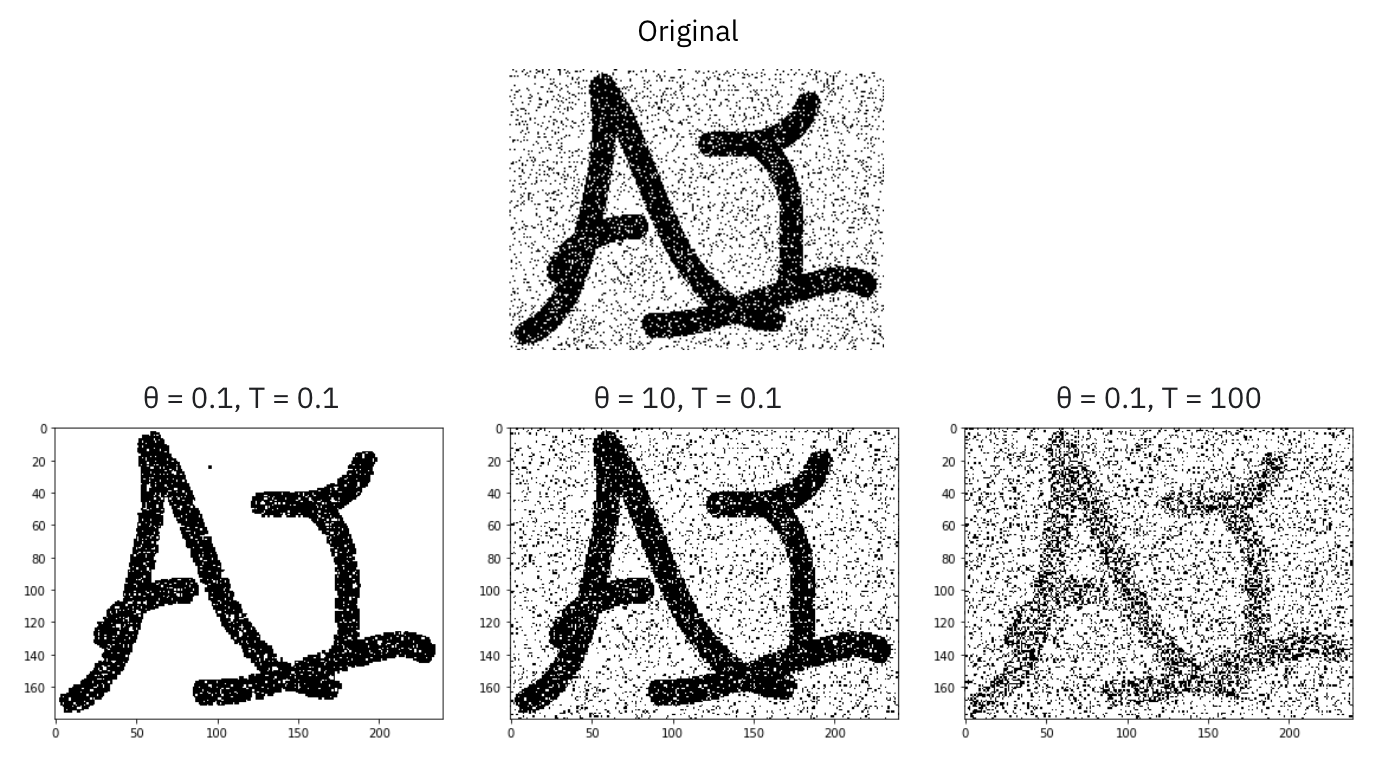

#### Test case 2: Pure noise
<div>
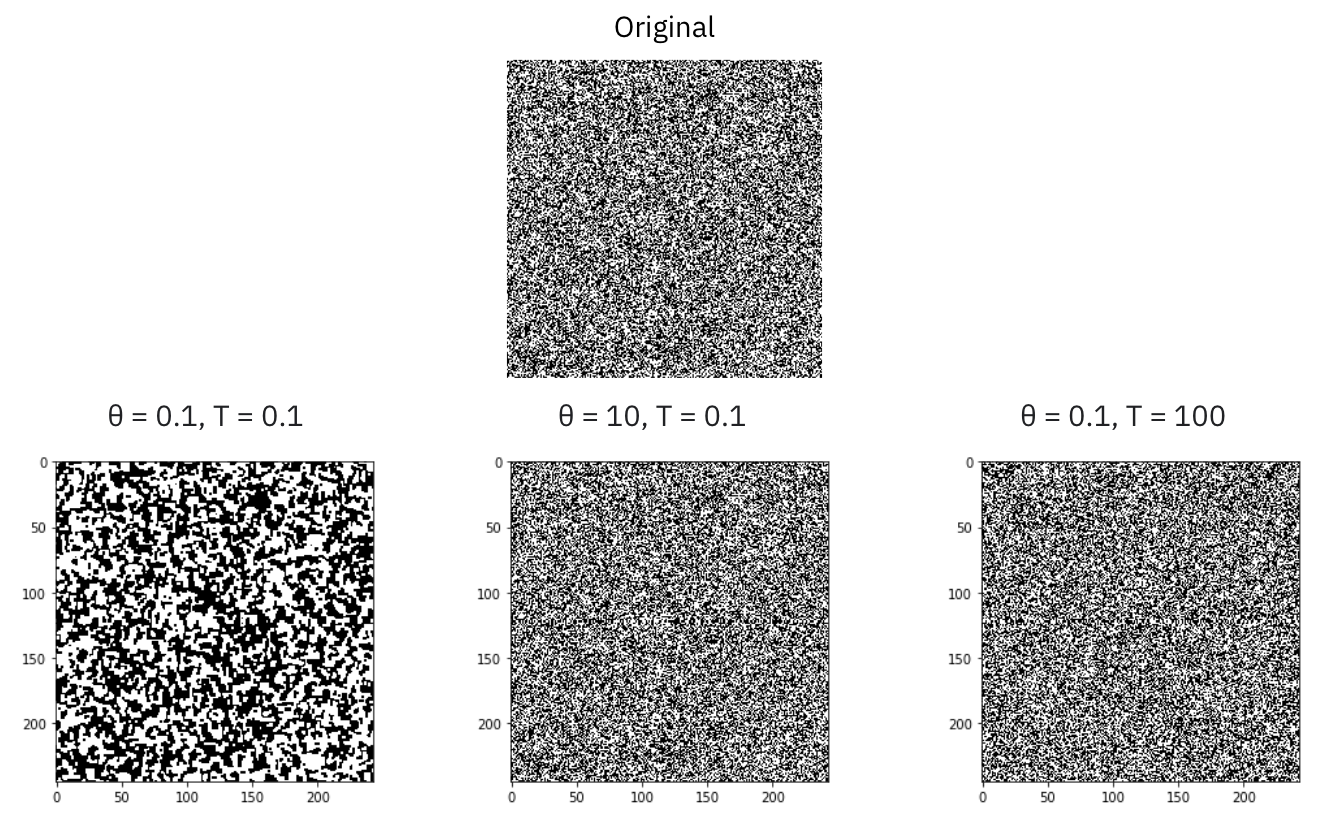
</div>

### Discussion
#### Alternatives to $c_{i, j}$
The problem with our rudimentary rule for $c_{i, j}$ is that it decides solely whether pixels are in the foregound or background by analyzing the pixels immediately around them. This can cause the algorithm to wrongfully admit pixels that are in fact in the foreground but happen to be surrounded by a disproportionate number of background pixels. A better rule for $c_{i, j}$ would be to take as input a larger area of surrounding pixels, since this would allow the algorithm to more effectively understand and interpret the surrounding of the pixel. For a pixel on a finger of a hand in front of some background, for example, such a rule would help the algorithm to interpret the pixel as part of a larger object in the foreground rather than being in the background simply because it is surrounded by background pixels.